# Shoulder Anomaly Detection Model 

In [2]:
import os
import numpy as np
import pandas as pd
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,MaxPooling2D,Flatten,Dropout
from keras import regularizers
from keras.optimizers import Adam, Adadelta
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras.models import model_from_json
import itertools
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16,preprocess_input,decode_predictions
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input
from keras.models import  Sequential
from sklearn import metrics

%matplotlib inline

Using TensorFlow backend.


#### For GPU use

In [2]:
# K.tensorflow_backend._get_available_gpus()

In [3]:
# assert len(K.tensorflow_backend._get_available_gpus()) > 0

## Loading the data

In [5]:
shoulder_df = pd.read_csv('train_shoulder.csv')
shoulder_test = pd.read_csv('test_shoulder.csv')

## Generating Train, Validation, Test Data

In [6]:
datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
#     featurewise_center = True,
#     featurewise_std_normalization = True,
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    validation_split = 0.2)

In [7]:
train_generator = datagen.flow_from_dataframe(
    dataframe = shoulder_df,
    directory = None,
    x_col = "path",
    y_col = "class_label",
    subset = "training",
    batch_size = 8,
    shuffle = True,
    class_mode = "categorical",
    target_size = (224, 224))

valid_generator = datagen.flow_from_dataframe(
    dataframe = shoulder_df,
    directory = None,
    x_col = "path",
    y_col = "class_label",
    subset = "validation",
    batch_size = 8,
    shuffle = True,
    class_mode = "categorical",
    target_size = (224, 224))

Found 6704 validated image filenames belonging to 2 classes.
Found 1675 validated image filenames belonging to 2 classes.


In [8]:
test_datagen=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input)

test_generator = test_datagen.flow_from_dataframe(
dataframe = shoulder_test,
directory = None,
x_col = "path",
y_col = "class_label",
batch_size = 8,
shuffle = False,
target_size = (224, 224))

Found 563 validated image filenames belonging to 2 classes.


## MobileNet Model

In [3]:
# Instantiate the model and add custom layers
base = MobileNet()
x = base.layers[-6].output
predictions = Dense(2, activation='softmax')(x)
model2 = Model(inputs=base.input, outputs=predictions)

x = model2.layers[-2].output
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)


predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=model2.input, outputs=predictions)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [118]:
# Unfreezing layers for training
for layer in model.layers[:]:
    layer.trainable = True

## Inception V3 Model

In [112]:
# input_tensor = Input(shape=(224, 224, 3))
# base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False, )

# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.5)(x)
# x = Dense(256, activation='relu')(x)

# predictions = Dense(2, activation='softmax')(x)

# model = Model(inputs=base_model.input, outputs=predictions)

In [113]:
# for layer in model.layers[:249]:
#    layer.trainable = False

In [114]:
# for layer in model.layers[249:]:
#    layer.trainable = True

##  Compile and run the model

In [120]:
model.compile(optimizer=Adam(lr=0.0001, decay=1e-6),loss='categorical_crossentropy',metrics=['accuracy'])

In [126]:
model.fit_generator(train_generator, steps_per_epoch=163, 
                    validation_data=valid_generator, validation_steps=20, epochs=7, verbose=1)

Epoch 1/7
163/163 [==============================] - 22s 132ms/step - loss: 0.5737 - acc: 0.7285 - val_loss: 0.7307 - val_acc: 0.5563
Epoch 2/7
163/163 [==============================] - 21s 131ms/step - loss: 0.5504 - acc: 0.7554 - val_loss: 0.8198 - val_acc: 0.4313
Epoch 3/7
163/163 [==============================] - 21s 128ms/step - loss: 0.5324 - acc: 0.7462 - val_loss: 0.6436 - val_acc: 0.6250
Epoch 4/7
163/163 [==============================] - 21s 129ms/step - loss: 0.5533 - acc: 0.7416 - val_loss: 0.6434 - val_acc: 0.5938
Epoch 5/7
163/163 [==============================] - 21s 126ms/step - loss: 0.5440 - acc: 0.7508 - val_loss: 0.6533 - val_acc: 0.5750
Epoch 6/7
163/163 [==============================] - 20s 125ms/step - loss: 0.5501 - acc: 0.7339 - val_loss: 0.6882 - val_acc: 0.5375
Epoch 7/7
163/163 [==============================] - 21s 130ms/step - loss: 0.5205 - acc: 0.7669 - val_loss: 0.6607 - val_acc: 0.5355


## Score the model

In [8]:
# Get the correct guesses
test_labels = test_generator.classes

In [10]:
with open('flask/models/XR_SHOULDER.json', 'r') as f:
    shoulder_model = model_from_json(f.read())
    shoulder_model.load_weights('flask/models/XR_SHOULDER.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
Y_pred = shoulder_model.predict_generator(test_generator, steps=71, verbose=1)

71/71 [==============================] - 40s 560ms/step


In [13]:
matrix = confusion_matrix(test_labels, Y_pred.argmax(axis=1))
matrix

array([[197,  88],
       [ 78, 200]])

In [14]:
print(metrics.classification_report(test_labels, Y_pred.argmax(axis=1), digits=3))

              precision    recall  f1-score   support

           0      0.716     0.691     0.704       285
           1      0.694     0.719     0.707       278

    accuracy                          0.705       563
   macro avg      0.705     0.705     0.705       563
weighted avg      0.706     0.705     0.705       563



In [15]:
test_classes = test_generator.class_indices

In [16]:
tc = np.array(list(test_classes.keys()))

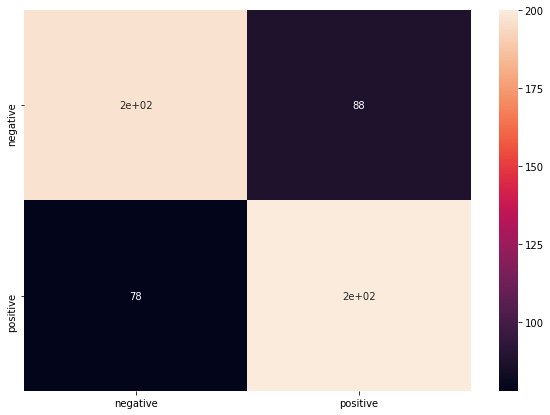

In [17]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(matrix, index = [i for i in tc],
                  columns = [i for i in tc])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [133]:
# Saving the model
with open('models/XR_SHOULDER.json', 'w') as f:
    f.write(model.to_json())
    
#Saving the model weights
model.save_weights("models/XR_SHOULDER.h5")